# Import Packages

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf                
from tqdm import tqdm
import sklearn
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
import pandas as pd


In [3]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [4]:
def load_data():

    
    datasets = ['../input/intel-image-classification/seg_train/seg_train', '../input/intel-image-classification/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [7]:
x = cv2.imread('/kaggle/input/intel-image-classification/seg_train/seg_train/buildings/0.jpg')
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

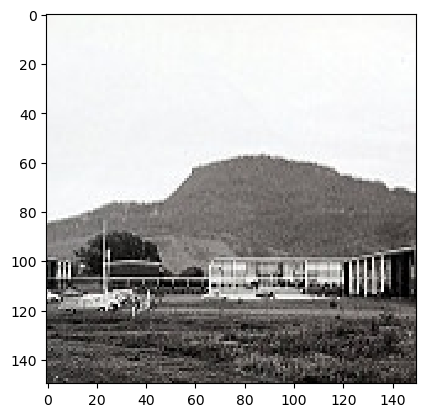

In [8]:
plt.imshow(x, interpolation='nearest')
plt.show()

In [9]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ../input/intel-image-classification/seg_train/seg_train


100%|██████████| 2404/2404 [00:10<00:00, 219.69it/s]


Loading ../input/intel-image-classification/seg_test/seg_test


100%|██████████| 553/553 [00:02<00:00, 226.70it/s]


In [10]:
train_images, train_labels = sklearn.utils.shuffle(train_images, train_labels, random_state=25)

In [11]:
train_images = train_images[:10000]

In [12]:
train_images.shape

(10000, 150, 150, 3)

In [13]:
train_labels = train_labels[:10000]

In [14]:
test_images = test_images[:1500]
test_labels = test_labels[:1500]

In [15]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 10000
Number of testing examples: 1500
Each image is of size: (150, 150)


# Checking if the classes are balanced

Train classes

<BarContainer object of 6 artists>

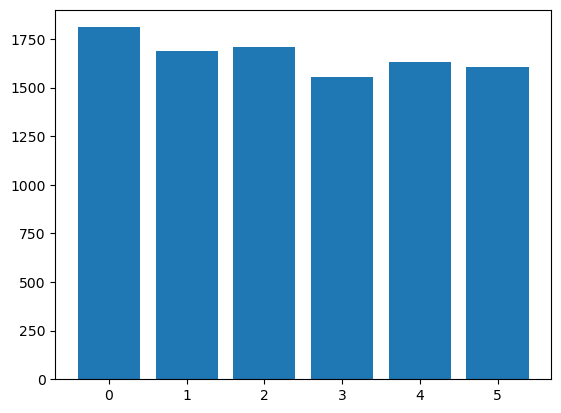

In [16]:
plt.bar(np.unique(train_labels, return_counts = True)[0], 
        np.unique(train_labels, return_counts = True)[1])

Test classes

<BarContainer object of 4 artists>

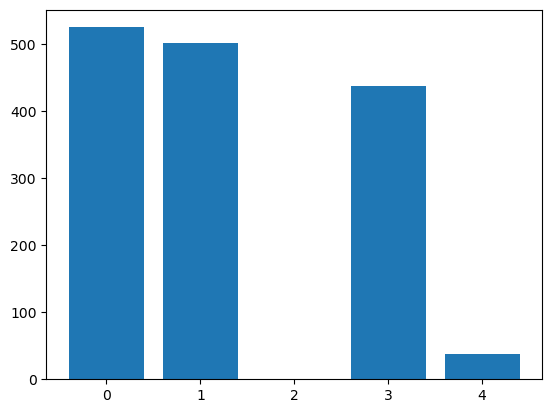

In [17]:
plt.bar(np.unique(test_labels, return_counts = True)[0], 
        np.unique(test_labels, return_counts = True)[1])

## Normalizing the data

In [18]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Viewing the images

In [19]:
index = random.randint(0, train_images.shape[0])

Text(0.5, 1.0, 'buildings')

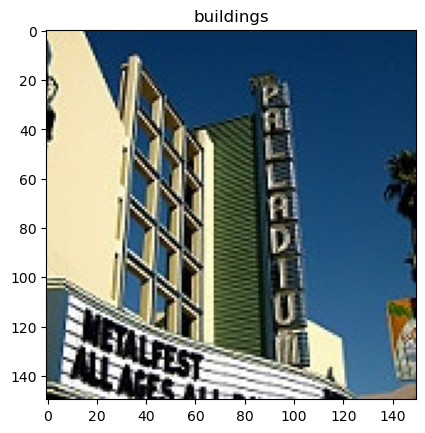

In [20]:
plt.imshow(train_images[index])
plt.title(class_names[train_labels[index]])

# Feature extraction with VGG ImageNet

We can extract features from VGG16.

In [21]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


Get the features directly from VGG16

In [22]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

47/47 [==============================] - 3s 55ms/step


## Training on top of VGG

Let's train a simple one-layer Neural Network on the features extracted from VGG.

In [23]:
train_features.shape

(10000, 4, 4, 512)

In [24]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (4, 4, 512)),
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(6, activation= 'softmax')
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=64, epochs=15, validation_split = 0.2)

Epoch 1/15
125/125 [==============================] - 3s 8ms/step - loss: 0.5510 - accuracy: 0.7924 - val_loss: 0.4127 - val_accuracy: 0.8455
Epoch 2/15
125/125 [==============================] - 1s 5ms/step - loss: 0.3178 - accuracy: 0.8861 - val_loss: 0.4160 - val_accuracy: 0.8410
Epoch 3/15
125/125 [==============================] - 1s 5ms/step - loss: 0.2382 - accuracy: 0.9179 - val_loss: 0.4340 - val_accuracy: 0.8390
Epoch 4/15
125/125 [==============================] - 1s 5ms/step - loss: 0.1807 - accuracy: 0.9355 - val_loss: 0.5205 - val_accuracy: 0.8260
Epoch 5/15
125/125 [==============================] - 1s 5ms/step - loss: 0.1408 - accuracy: 0.9517 - val_loss: 0.3964 - val_accuracy: 0.8645
Epoch 6/15
125/125 [==============================] - 1s 5ms/step - loss: 0.0993 - accuracy: 0.9689 - val_loss: 0.4151 - val_accuracy: 0.8530
Epoch 7/15
125/125 [==============================] - 1s 5ms/step - loss: 0.0863 - accuracy: 0.9716 - val_loss: 0.4739 - val_accuracy: 0.8490
Epoch 

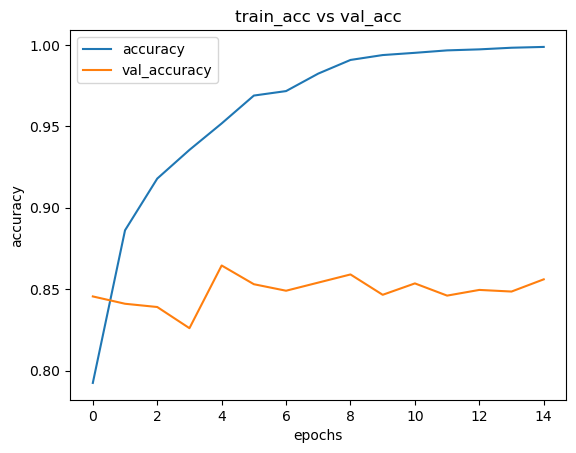

In [25]:
plt.plot(history2.history['accuracy'], label = 'accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

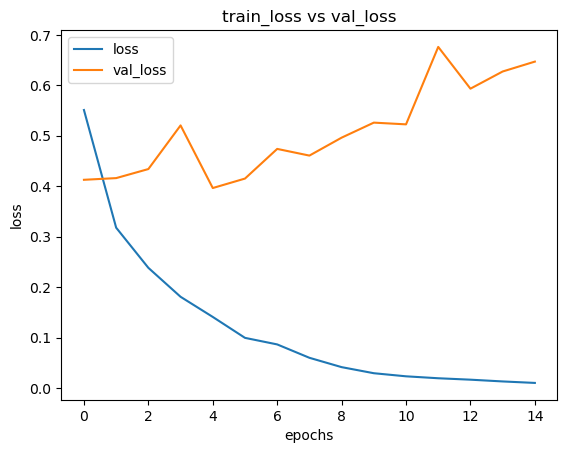

In [26]:
plt.plot(history2.history['loss'], label = 'loss')
plt.plot(history2.history['val_loss'], label = 'val_loss')
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()

In [28]:
test_loss = model2.evaluate(test_features, test_labels)

47/47 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.8687


In [29]:
predictions = model2.predict(test_features)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

47/47 [==============================] - 0s 2ms/step


In [30]:
index = random.randint(0, len(test_labels))


Text(0.5, 1.0, 'Predicted buildings, true label is buildings')

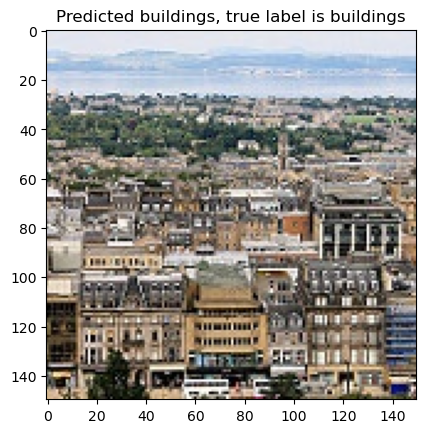

In [31]:
plt.imshow(test_images[index])
plt.title("Predicted {}, true label is {}".format(class_names[pred_labels[index]],
class_names[test_labels[index]])
)

In [32]:
sklearn.metrics.accuracy_score(test_labels, pred_labels)

0.8686666666666667

# Unfreezing VGG 

In [63]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [66]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

47/47 [==============================] - 1s 27ms/step


In [67]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) 
x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [69]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [70]:
new_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 1, 1, 64)         0  

In [71]:
history = new_model.fit(train_features, train_labels, batch_size=64, epochs=10, validation_split = 0.2)

Epoch 1/10
125/125 [==============================] - 10s 40ms/step - loss: 0.6886 - accuracy: 0.7435 - val_loss: 0.4046 - val_accuracy: 0.8650
Epoch 2/10
125/125 [==============================] - 4s 29ms/step - loss: 0.3606 - accuracy: 0.8795 - val_loss: 0.3479 - val_accuracy: 0.8935
Epoch 3/10
125/125 [==============================] - 4s 31ms/step - loss: 0.2826 - accuracy: 0.9007 - val_loss: 0.4502 - val_accuracy: 0.8490
Epoch 4/10
125/125 [==============================] - 4s 30ms/step - loss: 0.2257 - accuracy: 0.9233 - val_loss: 0.3039 - val_accuracy: 0.9075
Epoch 5/10
125/125 [==============================] - 4s 29ms/step - loss: 0.1928 - accuracy: 0.9308 - val_loss: 0.4606 - val_accuracy: 0.8490
Epoch 6/10
125/125 [==============================] - 4s 31ms/step - loss: 0.1439 - accuracy: 0.9524 - val_loss: 0.4021 - val_accuracy: 0.8860
Epoch 7/10
125/125 [==============================] - 4s 30ms/step - loss: 0.1523 - accuracy: 0.9494 - val_loss: 0.4038 - val_accuracy: 0.895

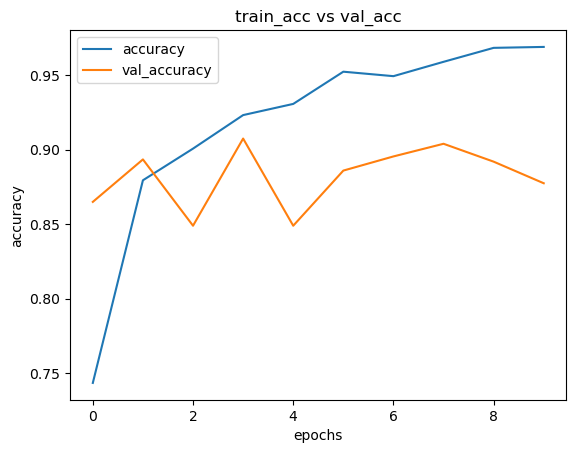

In [72]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

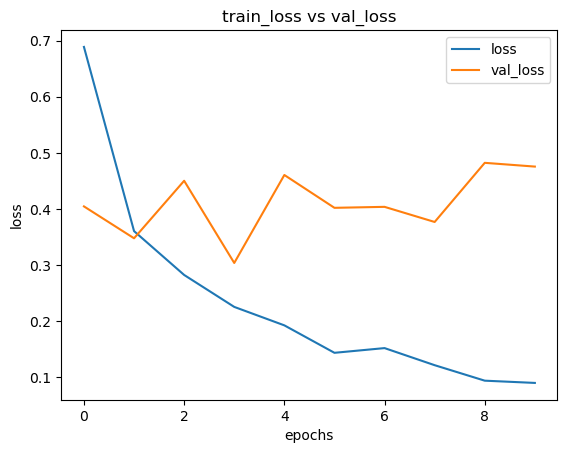

In [73]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()

In [78]:
predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)

47/47 [==============================] - 0s 7ms/step


In [79]:
sklearn.metrics.accuracy_score(test_labels, pred_labels)

0.9033333333333333